# 🚚 Vehicle Routing Problem (VRP) con Gurobi

Implementazione del modello matematico per il problema di routing dei veicoli con:
- Eliminazione sottocicli (MTZ)
- Vincoli di capacità
- Visualizzazioni interattive con NetworkX

## 📦 Importazione Librerie

In [1]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
import random

# Impostazioni visualizzazione
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['font.size'] = 11

print("✓ Librerie importate con successo")
print(f"Versione Gurobi: {gp.gurobi.version()}")

✓ Librerie importate con successo
Versione Gurobi: (12, 0, 3)


## 🎲 Generazione Dati di Esempio

Creiamo un'istanza del problema con clienti distribuiti casualmente su un piano 2D.

In [2]:
# Seed per riproducibilità
random.seed(42)
np.random.seed(42)

# Parametri del problema
n_clienti = 15  # numero di clienti (senza il deposito)
n_veicoli = 3   # numero di veicoli disponibili
capacita = 50   # capacità di ciascun veicolo

# Generazione coordinate (0 = deposito, 1..n = clienti)
n = n_clienti
coordinate = np.random.rand(n + 1, 2) * 100  # coordinate casuali [0, 100]
coordinate[0] = [50, 50]  # deposito al centro

# Generazione domande clienti
domande = np.random.randint(5, 15, size=n + 1)
domande[0] = 0  # deposito ha domanda 0

# Calcolo matrice delle distanze euclidee
def calcola_distanze(coord):
    n_nodi = len(coord)
    dist = np.zeros((n_nodi, n_nodi))
    for i in range(n_nodi):
        for j in range(n_nodi):
            if i != j:
                dist[i, j] = np.linalg.norm(coord[i] - coord[j])
    return dist

distanze = calcola_distanze(coordinate)

print(f"📍 Nodi totali: {n + 1} (1 deposito + {n} clienti)")
print(f"🚛 Veicoli disponibili: {n_veicoli}")
print(f"📦 Capacità veicolo: {capacita}")
print(f"📊 Domanda totale: {domande.sum()}")
print(f"📊 Domanda media per cliente: {domande[1:].mean():.1f}")

📍 Nodi totali: 16 (1 deposito + 15 clienti)
🚛 Veicoli disponibili: 3
📦 Capacità veicolo: 50
📊 Domanda totale: 140
📊 Domanda media per cliente: 9.3


## 📊 Visualizzazione Rete Iniziale

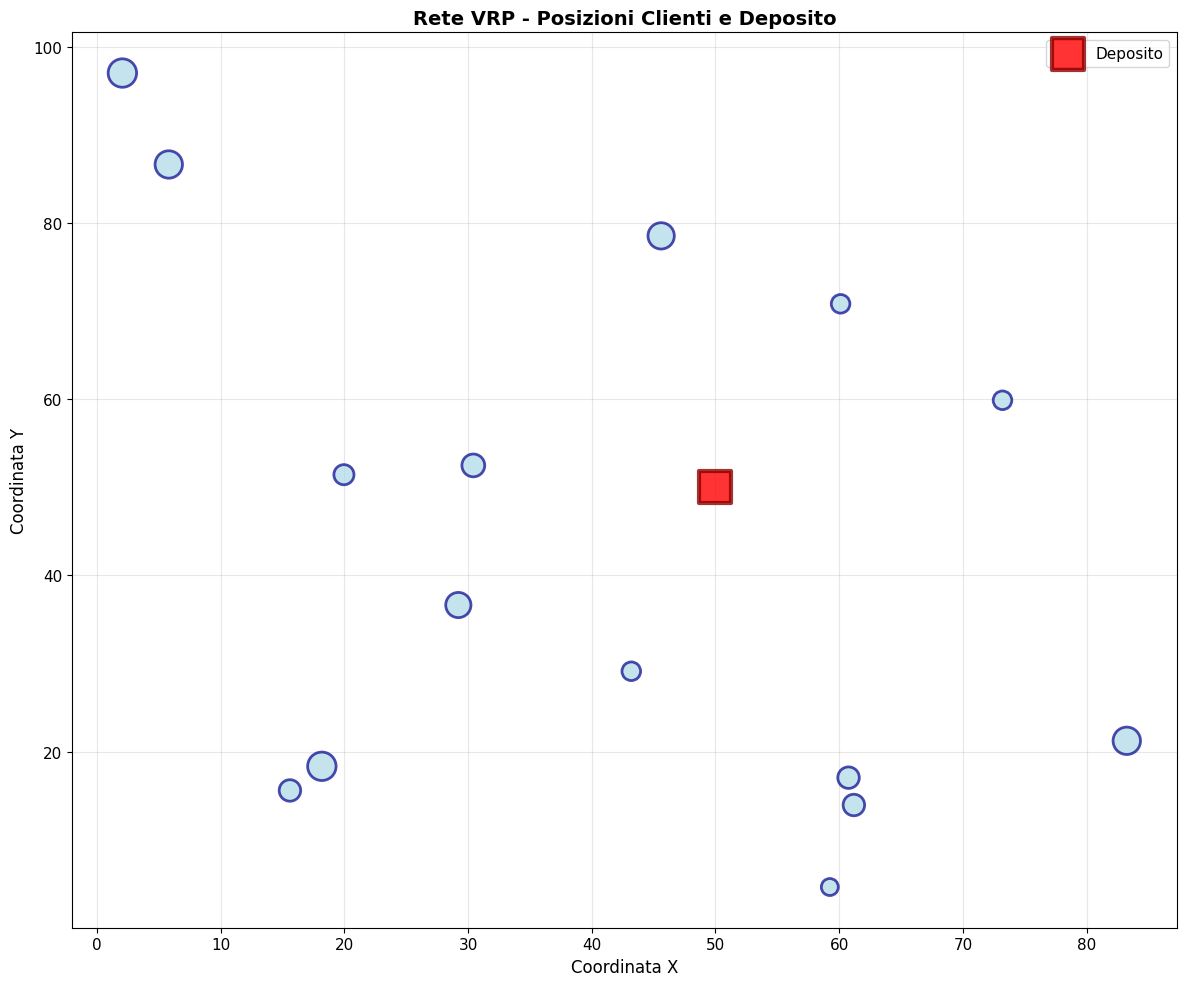

In [3]:
def visualizza_rete_iniziale(coord, domande):
    fig, ax = plt.subplots(1, 1, figsize=(12, 10))
    
    # Disegna clienti
    clienti_x = coord[1:, 0]
    clienti_y = coord[1:, 1]
    scatter = ax.scatter(clienti_x, clienti_y, s=domande[1:]*30, 
                        c='lightblue', edgecolors='darkblue', 
                        linewidths=2, alpha=0.7, zorder=3)
    
    # Disegna deposito
    ax.scatter(coord[0, 0], coord[0, 1], s=500, c='red', 
              marker='s', edgecolors='darkred', linewidths=3, 
              alpha=0.8, zorder=4, label='Deposito')
    

    
    ax.set_xlabel('Coordinata X', fontsize=12)
    ax.set_ylabel('Coordinata Y', fontsize=12)
    ax.set_title('Rete VRP - Posizioni Clienti e Deposito', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=11)
    
    plt.tight_layout()
    plt.show()

visualizza_rete_iniziale(coordinate, domande)

## 🔧 Creazione Modello Gurobi

Implementiamo il modello matematico completo con tutti i vincoli.

In [4]:
# Creazione modello
model = gp.Model("VRP")

# Insiemi
V = range(n + 1)  # nodi: 0 = deposito, 1..n = clienti
K = range(n_veicoli)  # veicoli
clienti = range(1, n + 1)  # solo clienti (senza deposito)

print("📝 Creazione variabili decisionali...")

# Variabili principali: x[i,j,k] = 1 se veicolo k va da i a j
x = {}
for k in K:
    for i in V:
        for j in V:
            if i != j:
                x[i, j, k] = model.addVar(vtype=GRB.BINARY, 
                                         name=f'x_{i}_{j}_{k}')

# Variabili ausiliarie MTZ per eliminazione sottocicli
u = {}
for i in V:
    if i == 0:
        u[i] = model.addVar(lb=0, ub=0, vtype=GRB.CONTINUOUS, name=f'u_{i}')
    else:
        u[i] = model.addVar(lb=1, ub=n, vtype=GRB.CONTINUOUS, name=f'u_{i}')

model.update()
print(f"✓ Variabili create: {model.NumVars}")

Set parameter Username
Set parameter LicenseID to value 2704465
Academic license - for non-commercial use only - expires 2026-09-08
📝 Creazione variabili decisionali...
✓ Variabili create: 736


### 🎯 Funzione Obiettivo

In [5]:
# Funzione obiettivo: minimizzare distanza totale
obj = gp.quicksum(distanze[i, j] * x[i, j, k] 
                  for k in K for i in V for j in V if i != j)
model.setObjective(obj, GRB.MINIMIZE)

print("✓ Funzione obiettivo impostata: min Σ c_ij * x_ijk")

✓ Funzione obiettivo impostata: min Σ c_ij * x_ijk


### 📏 Vincoli del Modello

In [6]:
print("📝 Aggiunta vincoli...\n")

# 1. Ogni cliente visitato esattamente una volta
for j in clienti:
    model.addConstr(
        gp.quicksum(x[i, j, k] for k in K for i in V if i != j) == 1,
        name=f'visita_cliente_{j}'
    )
print(f"✓ Vincolo 1: Ogni cliente visitato una volta ({len(clienti)} vincoli)")

# 2. Conservazione del flusso
for h in V:
    for k in K:
        model.addConstr(
            gp.quicksum(x[i, h, k] for i in V if i != h) == 
            gp.quicksum(x[h, j, k] for j in V if j != h),
            name=f'flusso_{h}_{k}'
        )
print(f"✓ Vincolo 2: Conservazione flusso ({(n+1)*n_veicoli} vincoli)")

# 3. Capacità veicolo
for k in K:
    model.addConstr(
        gp.quicksum(domande[j] * x[i, j, k] 
                   for j in clienti for i in V if i != j) <= capacita,
        name=f'capacita_{k}'
    )
print(f"✓ Vincolo 3: Capacità veicoli ({n_veicoli} vincoli)")

# 4. Partenza dal deposito (al più una volta per veicolo)
for k in K:
    model.addConstr(
        gp.quicksum(x[0, j, k] for j in clienti) <= 1,
        name=f'partenza_{k}'
    )
print(f"✓ Vincolo 4: Partenza deposito ({n_veicoli} vincoli)")

# 5. Ritorno al deposito (al più una volta per veicolo)
for k in K:
    model.addConstr(
        gp.quicksum(x[i, 0, k] for i in clienti) <= 1,
        name=f'ritorno_{k}'
    )
print(f"✓ Vincolo 5: Ritorno deposito ({n_veicoli} vincoli)")

# 6. Eliminazione sottocicli (MTZ)
for i in clienti:
    for j in clienti:
        if i != j:
            model.addConstr(
                u[i] - u[j] + n * gp.quicksum(x[i, j, k] for k in K) <= n - 1,
                name=f'mtz_{i}_{j}'
            )
print(f"✓ Vincolo 6: Eliminazione sottocicli MTZ ({n*(n-1)} vincoli)")

model.update()
print(f"\n📊 Statistiche modello:")
print(f"   - Variabili: {model.NumVars}")
print(f"   - Vincoli: {model.NumConstrs}")
print(f"   - Variabili binarie: {model.NumBinVars}")

📝 Aggiunta vincoli...

✓ Vincolo 1: Ogni cliente visitato una volta (15 vincoli)
✓ Vincolo 2: Conservazione flusso (48 vincoli)
✓ Vincolo 3: Capacità veicoli (3 vincoli)
✓ Vincolo 4: Partenza deposito (3 vincoli)
✓ Vincolo 5: Ritorno deposito (3 vincoli)
✓ Vincolo 6: Eliminazione sottocicli MTZ (210 vincoli)

📊 Statistiche modello:
   - Variabili: 736
   - Vincoli: 282
   - Variabili binarie: 720


## 🚀 Risoluzione del Modello

In [7]:
# Parametri solver
model.Params.TimeLimit = 300  # 5 minuti
model.Params.MIPGap = 0.01    # 1% ottimalità

print("🔍 Risoluzione in corso...\n")
print("=" * 60)
model.optimize()
print("=" * 60)

Set parameter TimeLimit to value 300
Set parameter MIPGap to value 0.01
🔍 Risoluzione in corso...

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G90)

CPU model: Apple M4
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Non-default parameters:
TimeLimit  300
MIPGap  0.01

Optimize a model with 282 rows, 736 columns and 3930 nonzeros
Model fingerprint: 0x35c244e4
Variable types: 16 continuous, 720 integer (720 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [3e+00, 1e+02]
  Bounds range     [1e+00, 2e+01]
  RHS range        [1e+00, 5e+01]
Presolve removed 0 rows and 1 columns
Presolve time: 0.00s
Presolved: 282 rows, 735 columns, 3930 nonzeros
Variable types: 15 continuous, 720 integer (720 binary)

Root relaxation: objective 2.257041e+02, 132 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth In

## 📈 Analisi Risultati

In [8]:
if model.status == GRB.OPTIMAL or model.status == GRB.TIME_LIMIT:
    print("\n" + "="*60)
    print("🎉 SOLUZIONE TROVATA")
    print("="*60)
    print(f"\n📊 Valore obiettivo: {model.ObjVal:.2f}")
    print(f"⏱️  Tempo di calcolo: {model.Runtime:.2f} secondi")
    if model.status == GRB.TIME_LIMIT:
        print(f"🔍 Gap di ottimalità: {model.MIPGap*100:.2f}%")
    
    # Estrazione soluzioni
    routes = {k: [] for k in K}
    
    for k in K:
        for i in V:
            for j in V:
                if i != j and x[i, j, k].X > 0.5:
                    routes[k].append((i, j))
    
    # Ricostruzione percorsi ordinati
    print("\n🛣️  PERCORSI DEI VEICOLI:\n")
    for k in K:
        if routes[k]:
            # Trova percorso ordinato partendo dal deposito
            percorso = [0]
            current = 0
            carico = 0
            distanza = 0
            
            while True:
                trovato = False
                for (i, j) in routes[k]:
                    if i == current:
                        percorso.append(j)
                        distanza += distanze[i, j]
                        if j != 0:
                            carico += domande[j]
                        current = j
                        trovato = True
                        break
                if not trovato or current == 0:
                    break
            
            print(f"Veicolo {k+1}:")
            print(f"  Percorso: {' → '.join(map(str, percorso))}")
            print(f"  Carico: {carico}/{capacita} ({carico/capacita*100:.1f}%)")
            print(f"  Distanza: {distanza:.2f}")
            print()
    
else:
    print("\n❌ Nessuna soluzione trovata!")
    print(f"Status: {model.status}")


🎉 SOLUZIONE TROVATA

📊 Valore obiettivo: 421.67
⏱️  Tempo di calcolo: 5.70 secondi

🛣️  PERCORSI DEI VEICOLI:

Veicolo 1:
  Percorso: 0 → 3 → 5 → 12 → 4 → 0
  Carico: 45/50 (90.0%)
  Distanza: 155.29

Veicolo 2:
  Percorso: 0 → 1 → 6 → 14 → 10 → 15 → 9 → 0
  Carico: 46/50 (92.0%)
  Distanza: 150.21

Veicolo 3:
  Percorso: 0 → 8 → 13 → 2 → 7 → 11 → 0
  Carico: 49/50 (98.0%)
  Distanza: 116.17



## 🎨 Visualizzazione Soluzione con NetworkX

/var/folders/t8/cj4t81wj4dv5k083bbjkj9fr0000gn/T/ipykernel_91160/3721307143.py:61: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(loc='upper right', fontsize=11)


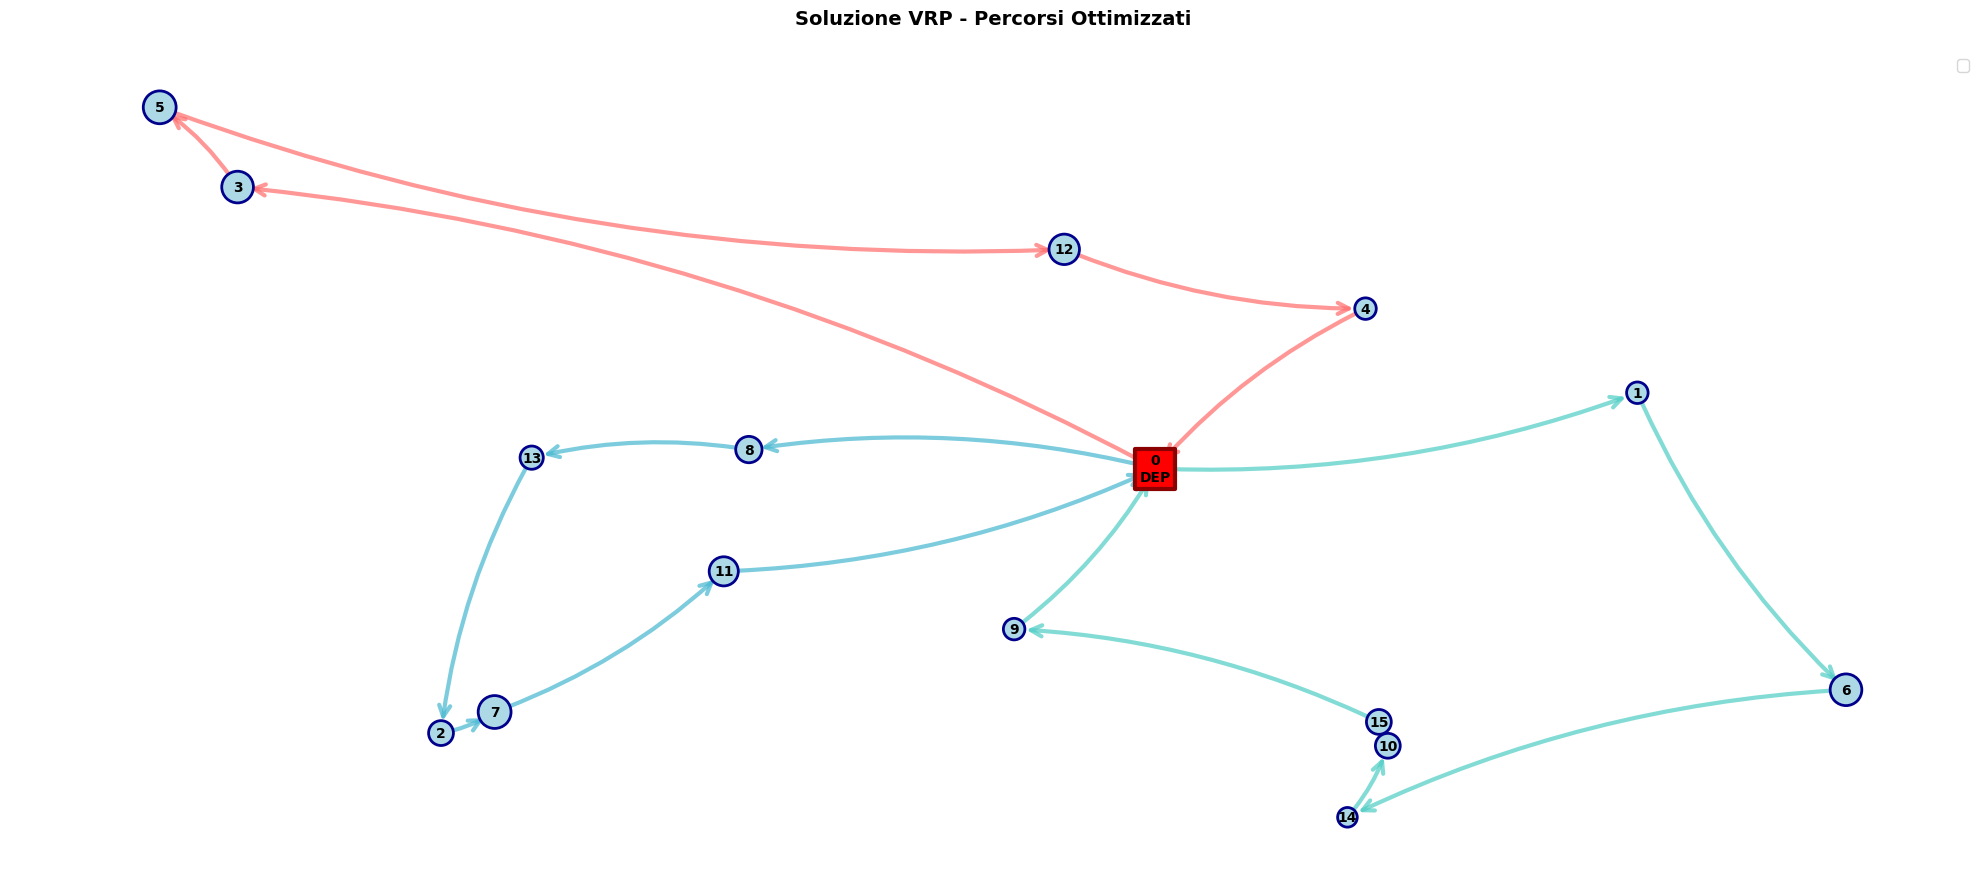

In [11]:
def visualizza_soluzione(coord, domande, routes, distanze):
    """
    Visualizza la soluzione del VRP usando NetworkX
    """
    fig, ax1 = plt.subplots(1, 1, figsize=(20, 9))  # Only one subplot for the first graph
    
    # Colori per veicoli diversi
    colori_veicoli = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8']
    
    # === GRAFICO 1: Soluzione con percorsi ===
    G = nx.DiGraph()
    
    # Aggiungi nodi
    for i in range(len(coord)):
        G.add_node(i, pos=coord[i], demand=domande[i])
    
    # Posizioni per NetworkX
    pos = {i: coord[i] for i in range(len(coord))}
    
    # Disegna nodi
    # Deposito
    nx.draw_networkx_nodes(G, pos, nodelist=[0], 
                          node_color='red', node_size=800, 
                          node_shape='s', edgecolors='darkred',
                          linewidths=3, ax=ax1)
    
    # Clienti
    node_sizes = [domande[i]*40 for i in range(1, len(coord))]
    nx.draw_networkx_nodes(G, pos, nodelist=list(range(1, len(coord))), 
                          node_color='lightblue', node_size=node_sizes,
                          edgecolors='darkblue', linewidths=2, ax=ax1)
    
    # Disegna archi per ogni veicolo con colori diversi
    for k, route in routes.items():
        if route:
            color = colori_veicoli[k % len(colori_veicoli)]
            edges = route
            
            # Aggiungi archi al grafo
            for (i, j) in edges:
                G.add_edge(i, j, vehicle=k, dist=distanze[i, j])
            
            # Disegna archi
            nx.draw_networkx_edges(G, pos, edgelist=edges,
                                  edge_color=color, width=3,
                                  arrows=True, arrowsize=20,
                                  arrowstyle='->', connectionstyle='arc3,rad=0.1',
                                  alpha=0.7, ax=ax1,
                                  label=f'Veicolo {k+1}')
    
    # Etichette nodi
    labels = {0: '0\nDEP'}
    for i in range(1, len(coord)):
        labels[i] = f'{i}'
    
    nx.draw_networkx_labels(G, pos, labels, font_size=10, 
                           font_weight='bold', ax=ax1)
    
    ax1.set_title('Soluzione VRP - Percorsi Ottimizzati', 
                 fontsize=14, fontweight='bold', pad=20)
    ax1.legend(loc='upper right', fontsize=11)
    ax1.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return G  # Return only the first graph

G = visualizza_soluzione(coordinate, domande, routes, distanze)

## 📊 Analisi Dettagliata del Grafo

In [12]:
if model.status == GRB.OPTIMAL or model.status == GRB.TIME_LIMIT:
    print("\n" + "="*60)
    print("📈 ANALISI DEL GRAFO NETWORKX")
    print("="*60)
    
    print(f"\n🔍 Proprietà del grafo:")
    print(f"   - Numero di nodi: {G.number_of_nodes()}")
    print(f"   - Numero di archi: {G.number_of_edges()}")
    print(f"   - È diretto: {G.is_directed()}")
    print(f"   - È connesso: {nx.is_weakly_connected(G)}")
    
    # Grado dei nodi
    print(f"\n📊 Grado dei nodi (in/out):")
    for node in sorted(G.nodes()):
        in_deg = G.in_degree(node)
        out_deg = G.out_degree(node)
        tipo = "DEPOSITO" if node == 0 else f"Cliente (q={domande[node]})"
        print(f"   Nodo {node:2d} ({tipo:20s}): in={in_deg}, out={out_deg}")
    
    # Cammini più lunghi
    print(f"\n🛣️  Lunghezza dei cammini dal deposito:")
    for k, route in routes.items():
        if route:
            # Ricostruisci percorso
            path = [0]
            current = 0
            dist_totale = 0
            
            while True:
                trovato = False
                for (i, j) in route:
                    if i == current:
                        path.append(j)
                        dist_totale += distanze[i, j]
                        current = j
                        trovato = True
                        break
                if not trovato or current == 0:
                    break
            
            print(f"   Veicolo {k+1}: {len(path)-1} archi, distanza {dist_totale:.2f}")
            print(f"              Percorso: {' → '.join(map(str, path))}")


📈 ANALISI DEL GRAFO NETWORKX

🔍 Proprietà del grafo:
   - Numero di nodi: 16
   - Numero di archi: 18
   - È diretto: True
   - È connesso: True

📊 Grado dei nodi (in/out):
   Nodo  0 (DEPOSITO            ): in=3, out=3
   Nodo  1 (Cliente (q=6)       ): in=1, out=1
   Nodo  2 (Cliente (q=8)       ): in=1, out=1
   Nodo  3 (Cliente (q=13)      ): in=1, out=1
   Nodo  4 (Cliente (q=6)       ): in=1, out=1
   Nodo  5 (Cliente (q=14)      ): in=1, out=1
   Nodo  6 (Cliente (q=13)      ): in=1, out=1
   Nodo  7 (Cliente (q=14)      ): in=1, out=1
   Nodo  8 (Cliente (q=9)       ): in=1, out=1
   Nodo  9 (Cliente (q=6)       ): in=1, out=1
   Nodo 10 (Cliente (q=8)       ): in=1, out=1
   Nodo 11 (Cliente (q=11)      ): in=1, out=1
   Nodo 12 (Cliente (q=12)      ): in=1, out=1
   Nodo 13 (Cliente (q=7)       ): in=1, out=1
   Nodo 14 (Cliente (q=5)       ): in=1, out=1
   Nodo 15 (Cliente (q=8)       ): in=1, out=1

🛣️  Lunghezza dei cammini dal deposito:
   Veicolo 1: 5 archi, distanza 1

## 🎯 Visualizzazione Statistica

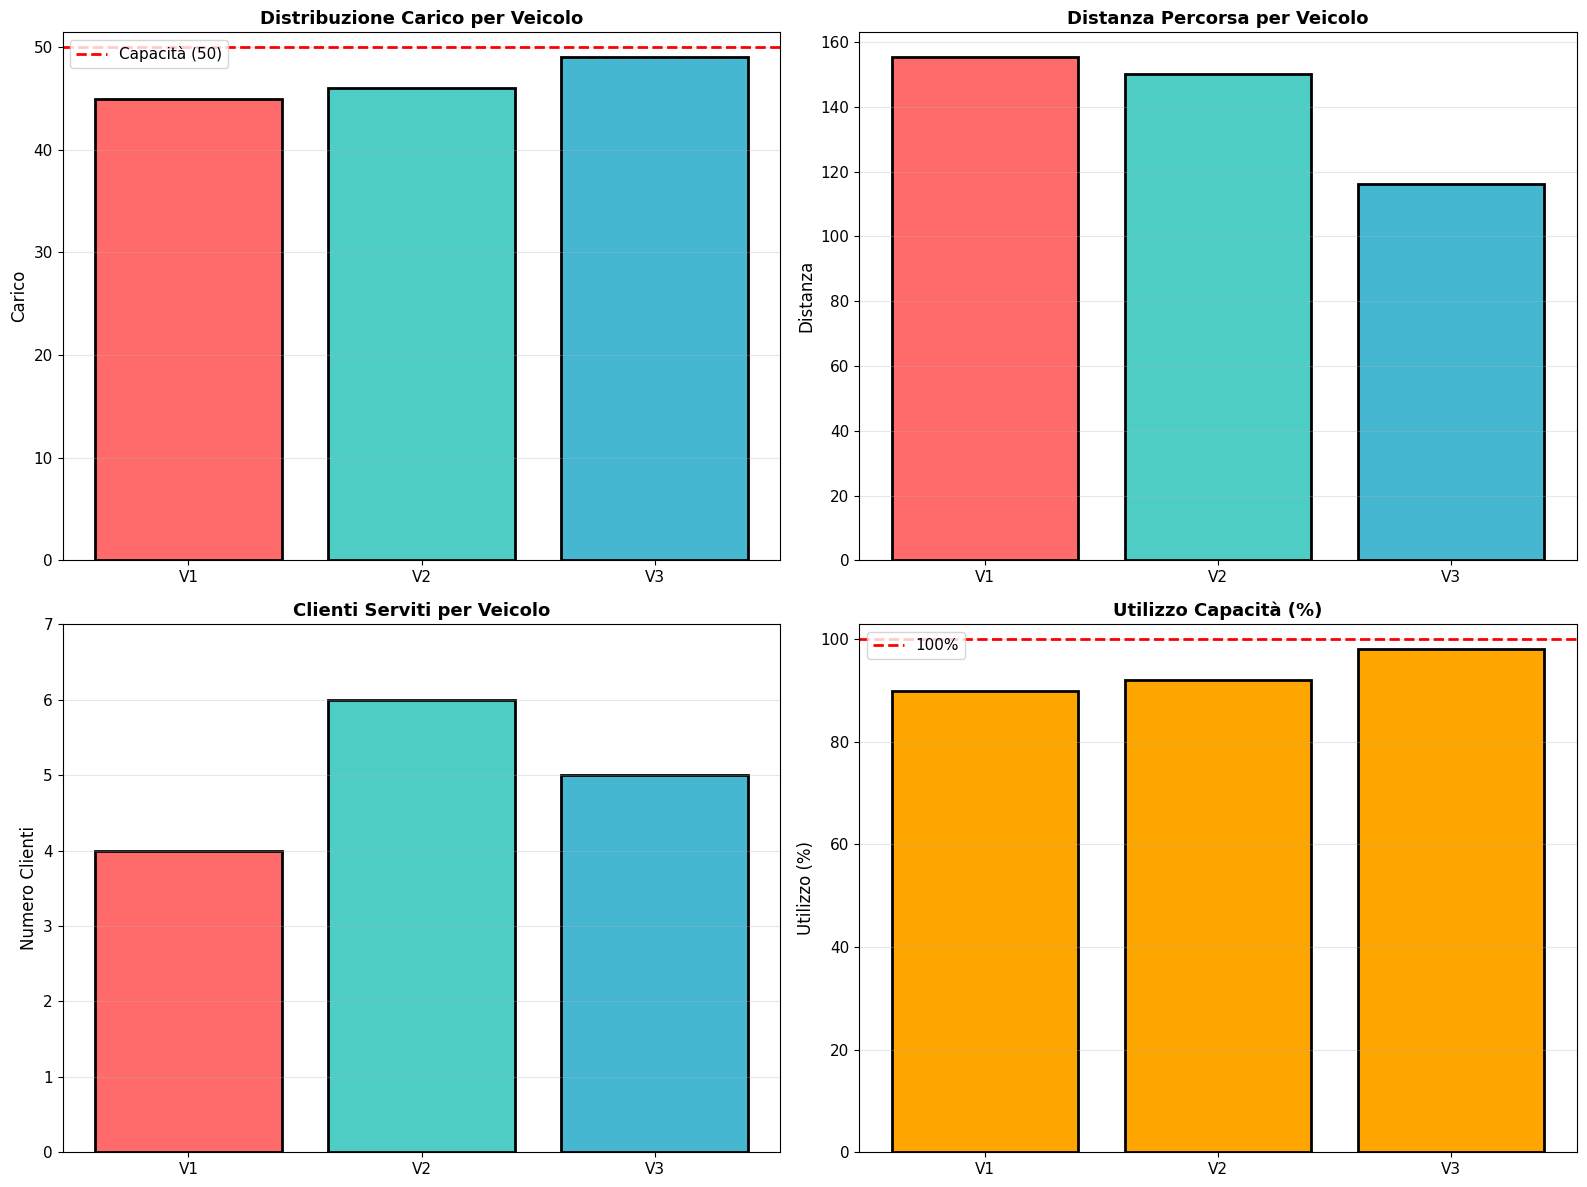


📊 Statistiche Finali:
   - Distanza totale: 421.67
   - Distanza media per veicolo: 140.56
   - Carico medio per veicolo: 46.67
   - Utilizzo medio capacità: 93.3%
   - Clienti medi per veicolo: 5.0


In [ ]:
if model.status == GRB.OPTIMAL or model.status == GRB.TIME_LIMIT:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Distribuzione carichi veicoli
    carichi = []
    labels_veicoli = []
    
    for k, route in routes.items():
        if route:
            carico = sum(domande[j] for (i, j) in route if j != 0)
            carichi.append(carico)
            labels_veicoli.append(f'V{k+1}')
    
    axes[0, 0].bar(labels_veicoli, carichi, color=['#FF6B6B', '#4ECDC4', '#45B7D1'][:len(carichi)],
                   edgecolor='black', linewidth=2)
    axes[0, 0].axhline(y=capacita, color='red', linestyle='--', linewidth=2, label=f'Capacità ({capacita})')
    axes[0, 0].set_ylabel('Carico', fontsize=12)
    axes[0, 0].set_title('Distribuzione Carico per Veicolo', fontsize=13, fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(axis='y', alpha=0.3)
    
    # 2. Distanze percorse
    distanze_veicoli = []
    
    for k, route in routes.items():
        if route:
            dist = sum(distanze[i, j] for (i, j) in route)
            distanze_veicoli.append(dist)
    
    axes[0, 1].bar(labels_veicoli, distanze_veicoli, 
                   color=['#FF6B6B', '#4ECDC4', '#45B7D1'][:len(distanze_veicoli)],
                   edgecolor='black', linewidth=2)
    axes[0, 1].set_ylabel('Distanza', fontsize=12)
    axes[0, 1].set_title('Distanza Percorsa per Veicolo', fontsize=13, fontweight='bold')
    axes[0, 1].grid(axis='y', alpha=0.3)
    
    # 3. Numero clienti per veicolo
    clienti_per_veicolo = []
    
    for k, route in routes.items():
        if route:
            n_clienti = len([j for (i, j) in route if j != 0])
            clienti_per_veicolo.append(n_clienti)
    
    axes[1, 0].bar(labels_veicoli, clienti_per_veicolo,
                   color=['#FF6B6B', '#4ECDC4', '#45B7D1'][:len(clienti_per_veicolo)],
                   edgecolor='black', linewidth=2)
    axes[1, 0].set_ylabel('Numero Clienti', fontsize=12)
    axes[1, 0].set_title('Clienti Serviti per Veicolo', fontsize=13, fontweight='bold')
    axes[1, 0].grid(axis='y', alpha=0.3)
    axes[1, 0].set_yticks(range(0, max(clienti_per_veicolo) + 2))
    
    # 4. Utilizzo capacità (%)
    utilizzo = [(c/capacita)*100 for c in carichi]
    
    colors_utilizzo = ['green' if u < 90 else 'orange' if u < 100 else 'red' for u in utilizzo]
    axes[1, 1].bar(labels_veicoli, utilizzo, color=colors_utilizzo,
                   edgecolor='black', linewidth=2)
    axes[1, 1].axhline(y=100, color='red', linestyle='--', linewidth=2, label='100%')
    axes[1, 1].set_ylabel('Utilizzo (%)', fontsize=12)
    axes[1, 1].set_title('Utilizzo Capacità (%)', fontsize=13, fontweight='bold')
    axes[1, 1].legend()
    axes[1, 1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Stampa statistiche
    print("\n📊 Statistiche Finali:")
    print(f"   - Distanza totale: {sum(distanze_veicoli):.2f}")
    print(f"   - Distanza media per veicolo: {np.mean(distanze_veicoli):.2f}")
    print(f"   - Carico medio per veicolo: {np.mean(carichi):.2f}")
    print(f"   - Utilizzo medio capacità: {np.mean(utilizzo):.1f}%")
    print(f"   - Clienti medi per veicolo: {np.mean(clienti_per_veicolo):.1f}")